## Useful Resources
- https://www.mssc.mu.edu/~daniel/pubs/RoweTalkMSCS_BiCubic.pdf
- https://gis.stackexchange.com/questions/451333/whats-the-difference-between-bicubic-interpolation-and-cubic-convolution
- https://yurkovak.medium.com/vision-transformer-vit-under-the-magnifying-glass-part-1-70be8d6661a7


In [14]:
import torchvision
import math
import numpy as np
import torch

In [15]:
# model = torchvision.models.vit_b_16(torchvision.models.ViT_B_16_Weights.IMAGENET1K_V1)
model = torchvision.models.vit_l_16(torchvision.models.ViT_L_16_Weights.IMAGENET1K_V1)

/home/fm-pc-lt-288/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [16]:
pos_embedding = model.state_dict()["encoder.pos_embedding"]
n, seq_length, hidden_dim = pos_embedding.shape

In [17]:
print(n,seq_length,hidden_dim)

1 197 1024


In [18]:
pos_embedding_token = pos_embedding[:, :1, :]
pos_embedding_img = pos_embedding[:, 1:, :]

In [19]:
pos_embedding_img.shape

torch.Size([1, 196, 1024])

In [20]:
pos_embedding_img = pos_embedding_img.permute(0,2,1)
seq_length_1d = int(math.sqrt(seq_length))
pos_embedding_img = pos_embedding_img.reshape(1, hidden_dim, seq_length_1d, seq_length_1d)
pos_embedding_img.shape

torch.Size([1, 1024, 14, 14])

In [21]:
n, dim, nrows, ncols = pos_embedding_img.shape
n, dim, nrows, ncols

(1, 1024, 14, 14)

In [22]:
def similarity_one_to_all(pos_embedding: torch.tensor, all_embeddings: torch.tensor) -> np.ndarray:
    cos_sim = torch.nn.CosineSimilarity(dim=-1)
    similarities = []
    # Compare the given pos_embedding to all other embeddings one by one
    for i in range(len(all_embeddings)):
        similarity = cos_sim(pos_embedding, all_embeddings[i])  # one values
        similarities.append(similarity)
    return np.array(similarities)

def similarity_all_to_all(pos_embeddings: torch.tensor, grid_h: int, grid_w: int):
    """
    Compute similarity between  positional embeddings, all to all
    :param pos_embeddings:  embeddings of shape (sequence_length x D),
                            sequence_length must be equal to grid_h * grid_w
    :param grid_h:          number of patches along Y axis
    :param grid_w:          number of patches along X axis
    :return:                grid_h x grid_w array of similarity heatmaps,
                            where similarity_heatmaps[i][j] stores similarity between embedding
                            for the patch at (i, j) to all the other embeddings
    """
    # Reshape pos. embeddings into a grid
    pos_embeddings_grid = pos_embeddings.reshape((grid_h, grid_w, -1))
    similarity_heatmaps = []
    # Go over patches rows
    for i in range(grid_h):
        row_i_heatmaps = []
        # Go over patches columns
        for j in range(grid_w):
            # Compare pos. embedding (i, j) to all other embeddings and reshape similarities into a heatmap
            similarities = similarity_one_to_all(pos_embeddings_grid[i, j], pos_embeddings)
            row_i_heatmaps.append(similarities.reshape((grid_h, grid_w)))
        similarity_heatmaps.append(row_i_heatmaps)

    return similarity_heatmaps

In [23]:
import matplotlib.pyplot as plt
def visualize_heatmaps(pos, nrows, ncols):
    similarity_heatmaps = similarity_all_to_all(pos, nrows, ncols)
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols)
    for i in range(nrows):
        for j in range(ncols):
            im = similarity_heatmaps[i][j]
            ax[i,j].imshow(im)
            ax[i,j].axis('off')
        

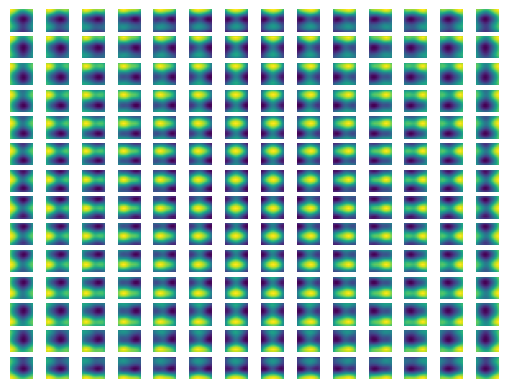

In [24]:
visualize_heatmaps(pos_embedding_img.permute(0,2,3,1).squeeze(0),nrows,ncols)

In [25]:
new_pos_embedding_img = torch.nn.functional.interpolate(
    pos_embedding_img,
    size = 21,
    mode = 'bilinear',
    align_corners=True
)

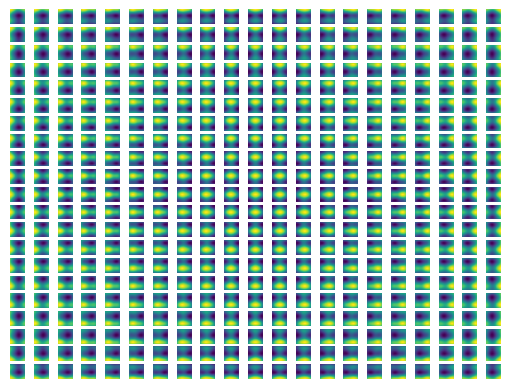

In [26]:
visualize_heatmaps(new_pos_embedding_img.permute(0,2,3,1).squeeze(0), 21, 21)